# Important Libraries 

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import DenseNet121, ResNet50 ,VGG16
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

# Path roots of the dataset

In [3]:
root = '/kaggle/input/deepfake-and-real-images'

train_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
val_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
test_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Test'

# Sub folders

In [4]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(val_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['Fake', 'Real']
Valid_dir Subfolders:  ['Fake', 'Real']
Test_dir Subfolders:  ['Fake', 'Real']


# Prepare and Load image data for training, validation, and testing using the ImageDataGenerator in Keras.

In [5]:
target_size = (224, 224)  # Reduced image size to 224x224
batch_size = 16  # Reduced batch size to 16

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure test data is not shuffled
)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [6]:
# Verify class distribution
print("Training class distribution:", train_generator.class_indices)
print("Validation class distribution:", val_generator.class_indices)

Training class distribution: {'Fake': 0, 'Real': 1}
Validation class distribution: {'Fake': 0, 'Real': 1}


# Load a pre-trained ResNet50 model in Keras. ResNet50 -> This refers to the ResNet architecture with 50 layers. ResNet (Residual Network) is a type of deep neural network that includes "residual connections" which help mitigate the vanishing gradient problem in deep networks by allowing gradients to flow more easily through the network during training.                                                                *** 256 refers to the height of the image.                                                                   *** 256 refers to the width of the image.                                                                    ***   3 refers to the number of color channels (RGB).

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Fine-tuning strategy for the ResNet50 model. It uses the pre-trained weights for feature extraction, adds custom layers (Global Average Pooling, Dense, and Dropout), and compiles the model with a small learning rate for fine-tuning.

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout here to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze only the last few layers for fine-tuning
for layer in base_model.layers[:150]:  # Freeze the first 150 layers
    layer.trainable = False
for layer in base_model.layers[150:]:  # Unfreeze the last few layers
    layer.trainable = True

In [9]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
]


# Fitting 

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1121s 249ms/step - accuracy: 0.7683 - loss: 0.4553 - val_accuracy: 0.7949 - val_loss: 0.4514 - learning_rate: 1.0000e-05
Epoch 2/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 924s 211ms/step - accuracy: 0.8875 - loss: 0.2643 - val_accuracy: 0.8363 - val_loss: 0.3869 - learning_rate: 1.0000e-05
Epoch 3/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 923s 211ms/step - accuracy: 0.9126 - loss: 0.2079 - val_accuracy: 0.8970 - val_loss: 0.2441 - learning_rate: 1.0000e-05
Epoch 4/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 923s 211ms/step - accuracy: 0.9302 - loss: 0.1715 - val_accuracy: 0.9050 - val_loss: 0.2310 - learning_rate: 1.0000e-05
Epoch 5/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 923s 211ms/step - accuracy: 0.9413 - loss: 0.1439 - val_accuracy: 0.9099 - val_loss: 0.2152 - learning_rate: 1.0000e-05
Epoch 6/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 922s 211ms/step - accuracy: 0.9518 - loss: 0.1187 - val_accuracy: 0.9166 - val_loss: 0.2202 - learning_rate: 1.0000e-05
Epoch 7/10
4376/4376 ━━━━━━

# Evaluate the model

In [11]:
test_metrics = model.evaluate(test_generator)
print("Test metrics:", test_metrics[1])

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
341/341 ━━━━━━━━━━━━━━━━━━━━ 75s 220ms/step - accuracy: 0.8731 - loss: 0.2815
Test metrics: 0.842824399471283


# Accuracy ,Plot training & validation accuracy values

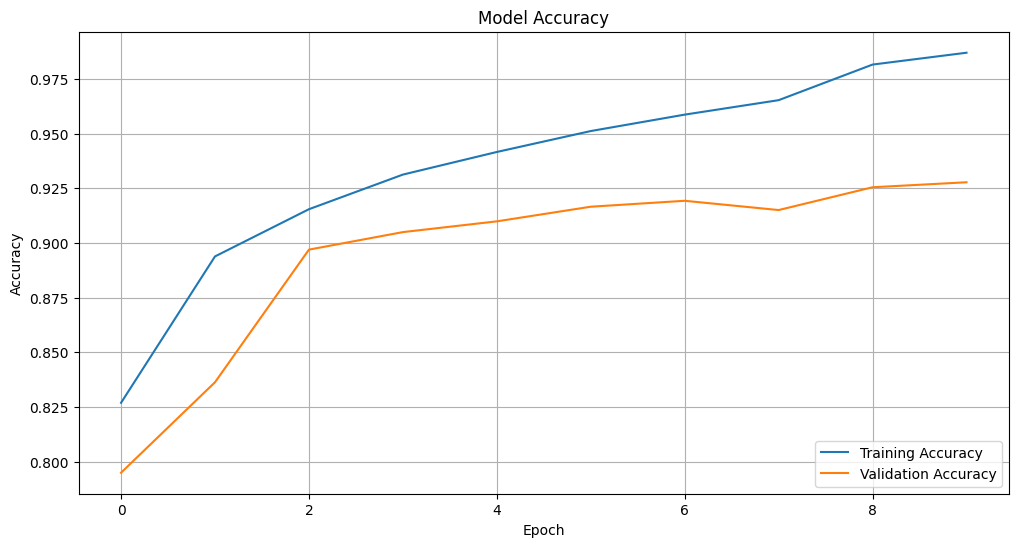

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training & validation loss values

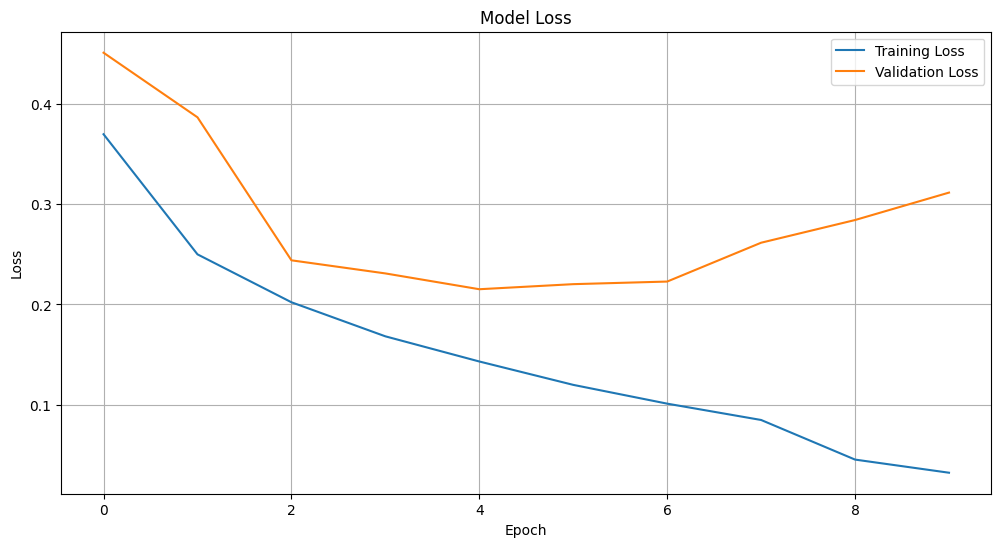

In [13]:

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Generate predictions on the test set

# The classification report

In [14]:

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# The model output is the probability of the image being real
# Convert probabilities to percentage
predicted_percentages = predictions * 100

# Convert to predicted classes with a threshold of 50%
predicted_classes = np.where(predicted_percentages > 50, 1, 0)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


print(classification_report(true_classes, predicted_classes, target_names=class_labels))

341/341 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step
              precision    recall  f1-score   support

        Fake       0.82      0.88      0.85      5492
        Real       0.87      0.81      0.84      5413

    accuracy                           0.84     10905
   macro avg       0.84      0.84      0.84     10905
weighted avg       0.84      0.84      0.84     10905



# The Confusion matrix

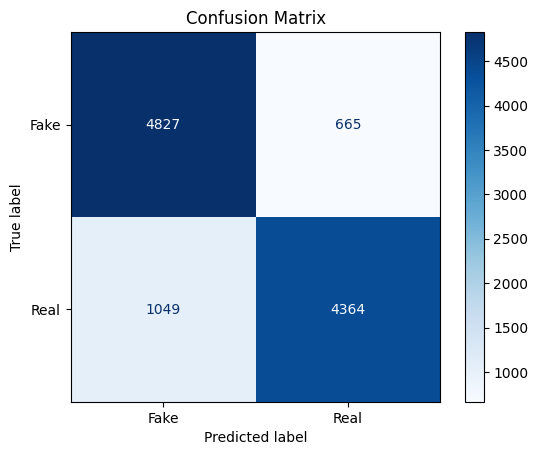

In [15]:

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


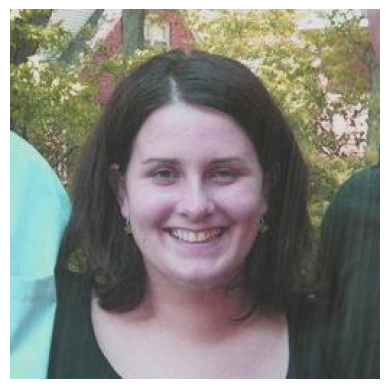

The model predicts this image is 'real' with a confidence of 90.45%.
The model predicts this image is 'fake' with a confidence of 9.55%.


In [16]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    # Load image
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert image to array
    img_array = image.img_to_array(img)
    
    # Rescale the image
    img_array = img_array / 255.0
    
    # Expand dimensions to match the input shape
    img_array = np.expand_dims(img_array, axis=0)
    
    return img, img_array

# Provide the path to your image
img_path = '/kaggle/input/deepfake-and-real-images/Dataset/Test/Real/real_1000.jpg'
target_size = (256, 256)  # Make sure this matches your model's input size

# Load and preprocess the image
img, img_array = load_and_preprocess_image(img_path, target_size)

# Make a prediction
prediction = model.predict(img_array)

# Get the percentage for both classes
real_confidence = prediction[0][0] * 100
fake_confidence = (1 - prediction[0][0]) * 100

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Print the results
print(f"The model predicts this image is 'real' with a confidence of {real_confidence:.2f}%.")
print(f"The model predicts this image is 'fake' with a confidence of {fake_confidence:.2f}%.")

In [16]:
# Load VGG16 model with pre-trained weights, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Creating a custom model -> VGG16 model (Pre-trained)

# Custom layers on top to fine-tune the model 

In [17]:
# Add custom layers on top of VGG16

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-3:]:  # Unfreeze the last 4 layers (customize this as needed)
    layer.trainable = True

# Recompile the model after making layers trainable
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # You can reduce the learning rate further if needed
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [18]:
# Define callbacks
callbacks = [
    #ModelCheckpoint('vgg16_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
]

In [19]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,
    callbacks=callbacks
)

Epoch 1/4


2024-08-29 12:07:16.082997: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[32,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,64,64]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-29 12:07:16.571247: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.488409293s
Trying algorithm eng12{k11=2} for conv (f32[32,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,64,64]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_qu

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1848s 570ms/step - accuracy: 0.8293 - loss: 0.3472 - val_accuracy: 0.9751 - val_loss: 0.0719 - learning_rate: 1.0000e-05
Epoch 2/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1785s 571ms/step - accuracy: 0.9760 - loss: 0.0643 - val_accuracy: 0.9895 - val_loss: 0.0310 - learning_rate: 1.0000e-05
Epoch 3/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1784s 571ms/step - accuracy: 0.9884 - loss: 0.0328 - val_accuracy: 0.9906 - val_loss: 0.0278 - learning_rate: 1.0000e-05
Epoch 4/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1783s 570ms/step - accuracy: 0.9918 - loss: 0.0227 - val_accuracy: 0.9956 - val_loss: 0.0140 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 4.


In [20]:
test_metrics = model.evaluate(test_generator)
print("Test metrics:", test_metrics[1])

625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 172ms/step - accuracy: 0.9950 - loss: 0.0138
Test metrics: 0.9940500259399414


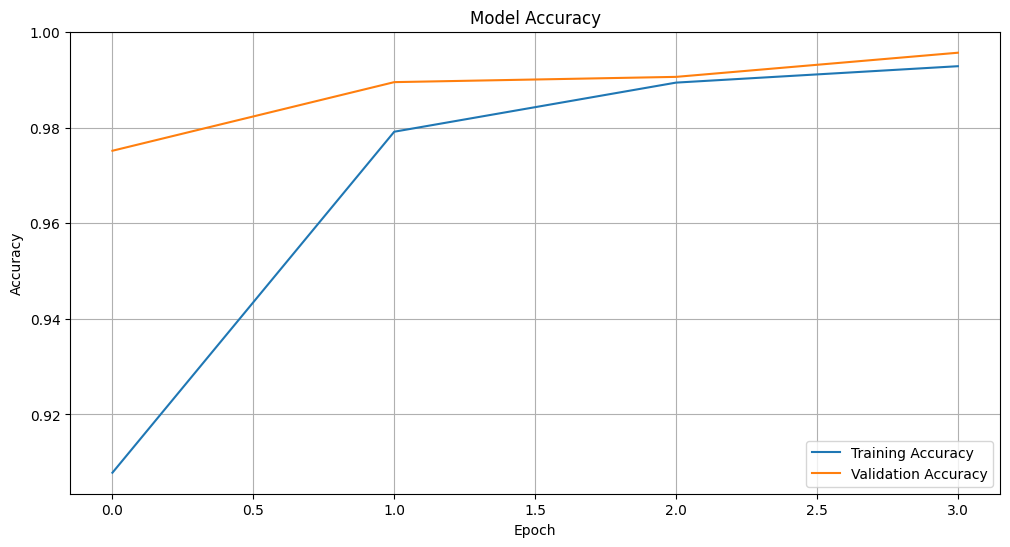

In [21]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

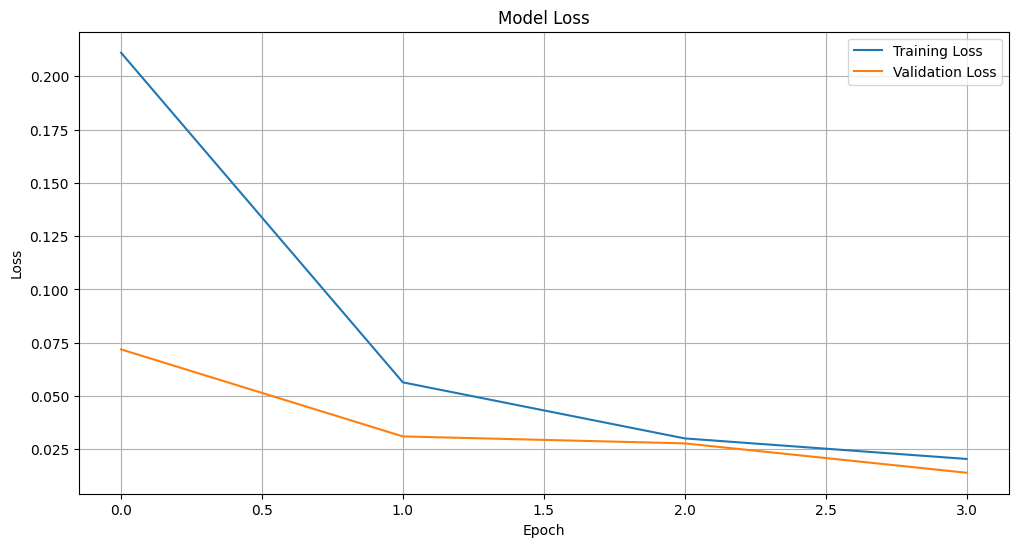

In [22]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [23]:
# Generate predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# The model output is the probability of the image being real
# Convert probabilities to percentage
predicted_percentages = predictions * 100

# Convert to predicted classes with a threshold of 50%
predicted_classes = np.where(predicted_percentages > 50, 1, 0)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

625/625 ━━━━━━━━━━━━━━━━━━━━ 106s 169ms/step
              precision    recall  f1-score   support

        fake       0.99      1.00      0.99     10000
        real       1.00      0.99      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



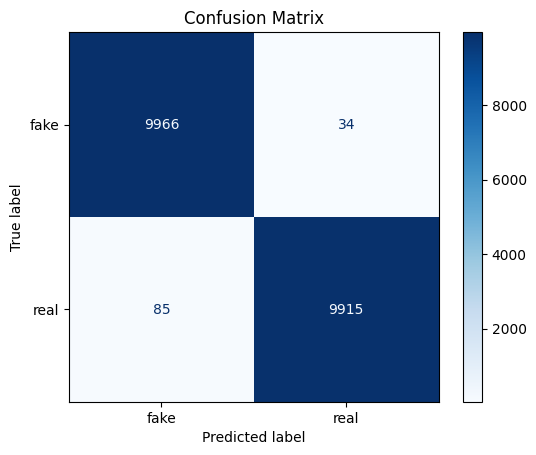

In [24]:
# 3. Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 4. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


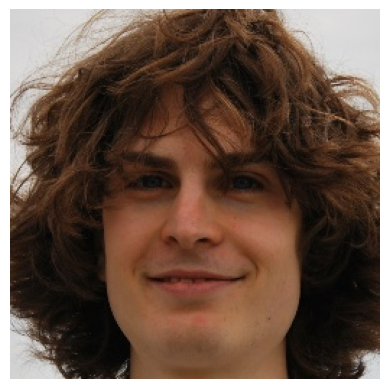

The model predicts this image is 'real' with a confidence of 99.98%.
The model predicts this image is 'fake' with a confidence of 0.02%.


In [25]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    # Load image
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert image to array
    img_array = image.img_to_array(img)
    
    # Rescale the image
    img_array = img_array / 255.0
    
    # Expand dimensions to match the input shape
    img_array = np.expand_dims(img_array, axis=0)
    
    return img, img_array

# Provide the path to your image
img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00093.jpg'
target_size = (256, 256)  # Make sure this matches your model's input size

# Load and preprocess the image
img, img_array = load_and_preprocess_image(img_path, target_size)

# Make a prediction
prediction = model.predict(img_array)

# Get the percentage for both classes
real_confidence = prediction[0][0] * 100
fake_confidence = (1 - prediction[0][0]) * 100

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Print the results
print(f"The model predicts this image is 'real' with a confidence of {real_confidence:.2f}%.")
print(f"The model predicts this image is 'fake' with a confidence of {fake_confidence:.2f}%.")

In [26]:

import os

# Check the current working directory
print(os.getcwd())

# Save the model
model.save('Vgg16_model.h5')

# List files in the current directory to confirm the save
print(os.listdir())


/kaggle/working
['__notebook__.ipynb', 'Vgg16_model.h5']


In [27]:
# Save only the weights
model.save_weights('Vgg16_model.weights.h5')